In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import os

xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
os.environ["XLA_FLAGS"] = xla_flags
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["MUJOCO_GL"] = "egl"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [34]:
import functools
import json
from datetime import datetime

import jax
import jax.numpy as jp
import matplotlib.pyplot as plt
import mediapy as media
import mujoco
import wandb
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from etils import epath
from flax.training import orbax_utils
from IPython.display import clear_output, display
from orbax import checkpoint as ocp

from mujoco_playground import manipulation, wrapper
from mujoco_playground.config import manipulation_params

# Enable persistent compilation cache.
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [10]:
env_name = "LeapCubeReorientTouch"
env_cfg = manipulation.get_default_config(env_name)
randomizer = manipulation.get_domain_randomizer(env_name)
ppo_params = manipulation_params.brax_ppo_config(env_name)

In [11]:
## First run.
ppo_params.num_timesteps = 200_000_000
ppo_params.num_evals = 20

## Second run (add torque limits & frictionloss).
# ppo_params.num_timesteps = 100_000_000
# ppo_params.num_evals = 10
# env_cfg.obs_noise.random_ori_injection_prob = 0.1
# ppo_params.learning_rate = 1e-4

In [12]:
from pprint import pprint

pprint(ppo_params)

env_cfg.obs_noise.scales.cube_ori = 0.2
env_cfg.obs_noise.scales.cube_pos = 0.04

pprint(env_cfg)

pprint(ppo_params)


action_repeat: 1
batch_size: 256
discounting: 0.99
entropy_cost: 0.01
episode_length: 1000
learning_rate: 0.0003
network_factory:
  policy_hidden_layer_sizes: &id001 !!python/tuple
  - 512
  - 256
  - 128
  policy_obs_key: state
  value_hidden_layer_sizes: *id001
  value_obs_key: privileged_state
normalize_observations: true
num_envs: 8192
num_evals: 20
num_minibatches: 32
num_resets_per_eval: 1
num_timesteps: 200000000
num_updates_per_batch: 4
reward_scaling: 1.0
unroll_length: 40

action_repeat: 1
action_scale: 0.5
binarize_touch_sensors: true
ctrl_dt: 0.05
ema_alpha: 1.0
episode_length: 1000
history_len: 1
obs_noise:
  level: 1.0
  random_ori_injection_prob: 0.0
  scales:
    cube_ori: 0.2
    cube_pos: 0.04
    joint_pos: 0.05
pert_config:
  angular_velocity_pert:
  - 0.0
  - 0.5
  enable: false
  linear_velocity_pert:
  - 0.0
  - 3.0
  pert_duration_steps:
  - 1
  - 100
  pert_wait_steps:
  - 60
  - 150
reward_config:
  scales:
    action_rate: -0.001
    energy: -0.001
    hand_p

In [ ]:
# Setup wandb logging.
USE_WANDB = False

if USE_WANDB:
  wandb.init(project="mjxrl", config=env_cfg)
  wandb.config.update({
      "env_name": env_name,
  })

In [ ]:
SUFFIX = "2xnoisystatewithtouch"

# FINETUNE_PATH = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/LeapCubeReorient-20250103-170903"
# FINETUNE_PATH = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/LeapCubeReorient-20250103-174028"
# FINETUNE_PATH = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/LeapCubeReorient-20250103-201052"
FINETUNE_PATH = None

# Generate unique experiment name.
now = datetime.now()
timestamp = now.strftime("%Y%m%d-%H%M%S")
exp_name = f"{env_name}-{timestamp}"
if SUFFIX is not None:
  exp_name += f"-{SUFFIX}"
print(f"{exp_name}")

# Possibly restore from the latest checkpoint.
if FINETUNE_PATH is not None:
  FINETUNE_PATH = epath.Path(FINETUNE_PATH)
  latest_ckpts = list(FINETUNE_PATH.glob("*"))
  latest_ckpts = [ckpt for ckpt in latest_ckpts if ckpt.is_dir()]
  latest_ckpts.sort(key=lambda x: int(x.name))
  latest_ckpt = latest_ckpts[-1]
  restore_checkpoint_path = latest_ckpt
  print(f"Restoring from: {restore_checkpoint_path}")
else:
  restore_checkpoint_path = None

LeapCubeReorientTouch-20250805-152307-2xnoisystatewithtouch


In [ ]:
ckpt_path = epath.Path("checkpoints").resolve() / exp_name
ckpt_path.mkdir(parents=True, exist_ok=True)
print(f"{ckpt_path}")

with open(ckpt_path / "config.json", "w") as fp:
  json.dump(env_cfg.to_dict(), fp, indent=4)

/home/edward/projects/mujoco_playground/checkpoints/LeapCubeReorientTouch-20250805-152307-2xnoisystatewithtouch


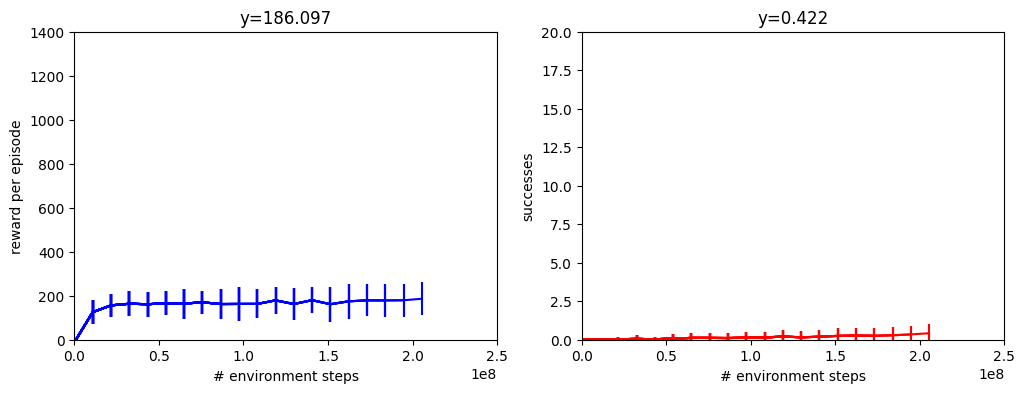

time to jit: 0:02:25.140668
time to train: 1:15:17.814026


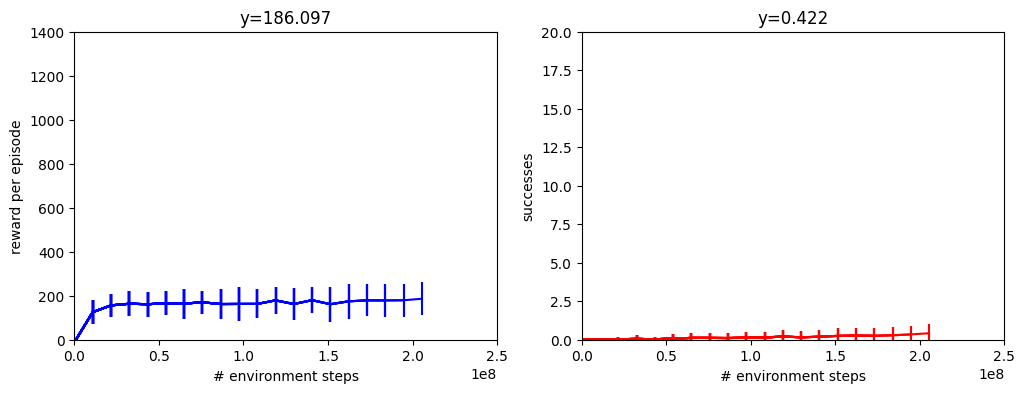

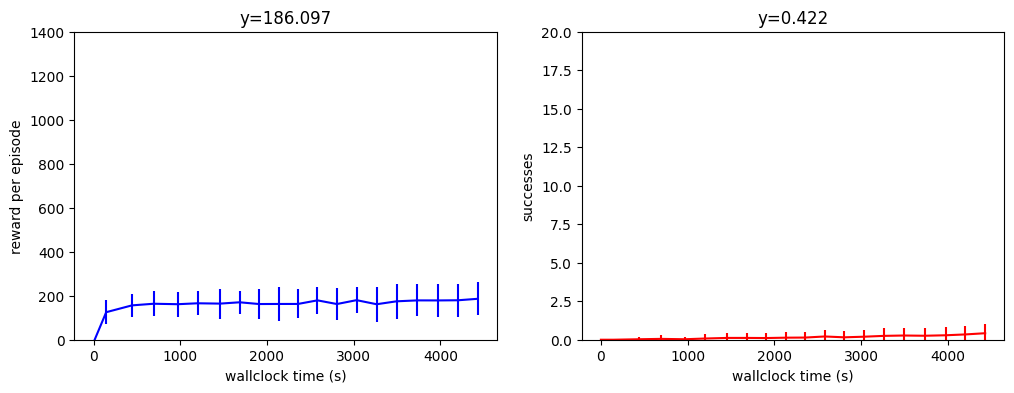

In [ ]:
x_data, y_data, y_dataerr = [], [], []
s_data, s_dataerr = [], []
times = [datetime.now()]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))


def progress(num_steps, metrics):
  # Log to wandb.
  if USE_WANDB:
    wandb.log(metrics, step=num_steps)

  # Plot.
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])
  s_data.append(metrics["eval/episode_reward/success"])
  s_dataerr.append(metrics["eval/episode_reward/success_std"])

  # Plot reward vs steps.
  axes[0].set_xlim([0, ppo_params.num_timesteps * 1.25])
  axes[0].set_ylim([0, 1400.0])
  axes[0].set_xlabel("# environment steps")
  axes[0].set_ylabel("reward per episode")
  axes[0].set_title(f"y={y_data[-1]:.3f}")
  axes[0].errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  # Plot success vs steps.
  axes[1].set_xlim([0, ppo_params.num_timesteps * 1.25])
  axes[1].set_ylim([0, 20])
  axes[1].set_xlabel("# environment steps")
  axes[1].set_ylabel("successes")
  axes[1].set_title(f"y={s_data[-1]:.3f}")
  axes[1].errorbar(x_data, s_data, yerr=s_dataerr, color="red")

  display(plt.gcf())


def policy_params_fn(current_step, make_policy, params):
  del make_policy  # Unused.
  orbax_checkpointer = ocp.PyTreeCheckpointer()
  save_args = orbax_utils.save_args_from_target(params)
  path = ckpt_path / f"{current_step}"
  orbax_checkpointer.save(path, params, force=True, save_args=save_args)


training_params = dict(ppo_params)
del training_params["network_factory"]

train_fn = functools.partial(
  ppo.train,
  **training_params,
  network_factory=functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  ),
  restore_checkpoint_path=restore_checkpoint_path,
  progress_fn=progress,
  wrap_env_fn=wrapper.wrap_for_brax_training,
  policy_params_fn=policy_params_fn,
  randomization_fn=randomizer,
)

env = manipulation.load(env_name, config=env_cfg)
eval_env = manipulation.load(env_name, config=env_cfg)
make_inference_fn, params, _ = train_fn(environment=env, eval_env=eval_env)
if len(times) > 1:
  print(f"time to jit: {times[1] - times[0]}")
  print(f"time to train: {times[-1] - times[1]}")

# Make a final plot of reward and success vs WALLCLOCK time.
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_ylim([0, 1400.0])
axes[0].set_xlabel("wallclock time (s)")
axes[0].set_ylabel("reward per episode")
axes[0].set_title(f"y={y_data[-1]:.3f}")
axes[0].errorbar(
    [(t - times[0]).total_seconds() for t in times[:-1]],
    y_data,
    yerr=y_dataerr,
    color="blue",
)
axes[1].set_ylim([0, 20])
axes[1].set_xlabel("wallclock time (s)")
axes[1].set_ylabel("successes")
axes[1].set_title(f"y={s_data[-1]:.3f}")
axes[1].errorbar(
    [(t - times[0]).total_seconds() for t in times[:-1]],
    s_data,
    yerr=s_dataerr,
    color="red",
)
plt.show()

In [ ]:
import pickle
# Save normalizer and policy params to the checkpoint dir.
normalizer_params, policy_params, value_params = params
with open(ckpt_path / "params.pkl", "wb") as f:
  data = {
    "normalizer_params": normalizer_params,
    "policy_params": policy_params,
    "value_params": value_params,
  }
  pickle.dump(data, f)

In [ ]:
inference_fn = make_inference_fn(params, deterministic=True)
jit_inference_fn = jax.jit(inference_fn)

eval_env = manipulation.load(env_name, config=env_cfg)
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [ ]:
rng = jax.random.PRNGKey(1234)
rollout = [state := jit_reset(rng)]
actions = []
rewards = []
cube_angvel = []
cube_angacc = []
torques = []
for i in range(env_cfg.episode_length):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state)
  rewards.append({k[7:]: v for k, v in state.metrics.items() if k.startswith("reward/")})
  actions.append({
      "policy_output": ctrl,
      "motor_targets": state.info["motor_targets"],
  })
  torques.append(jp.linalg.norm(state.data.actuator_force))
  cube_angvel.append(env.get_object_angvel(state.data))
  cube_angacc.append(env.get_object_angacc(state.data))
  if state.done:
    print("Done detected, stopping rollout.")
    break
print(rollout[-1].info["success_count"])

2


In [ ]:
render_every = 1
fps = 1.0 / eval_env.dt / render_every
print(f"fps: {fps}")

traj = rollout[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False

eval_env.mj_model.stat.meansize = 0.02
eval_env.mj_model.stat.extent = 0.25
eval_env.mj_model.vis.global_.azimuth = 140
eval_env.mj_model.vis.global_.elevation = -25
frames = eval_env.render(
    traj, height=480, width=640, scene_option=scene_option, camera="side"
)
media.show_video(frames, fps=fps)
media.write_video(f"{env_name}.mp4", frames, fps=fps)

fps: 20.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:04<00:00, 225.02it/s]
